In this noteobook, we will build a spam detector using two different models, a decision tree and a naive Bayes model. A naive Bayes classifier calculates the probability of a sequence of words belonging to a class as proprotional to the product of the probability of each item in a sequence given the class.

Below we import the libraries we'll be using.


In [11]:
from sklearn import tree
import graphviz 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

Next we'll write a function to process the data into a dictionary of words and their number of occurances, `word_dict`, and a count of the number of words total, `lexiconsize`

In [12]:
# read in the vocabulary file 
def readvocab(vocab_path="vocab.txt"):
   # keep track of the number of words
    lexiconsize = 0
   # initialize an empty dictionary
    word_dict = {}
   # create a feature for unknown words
    word_dict["@unk"] = lexiconsize
    lexiconsize += 1
   # read in the vocabular file
    with open(vocab_path, "r") as f:
        data = f.readlines()
   # Process the file a line at a time.
    for line in data:
        # The count is the first 3 characters
        count = int(line[0:4])
        # The word is the rest of the string
        token = line[5:-1]
       # Create a feature if it’s appeared at least twice
        if count > 1: 
            word_dict[token] = lexiconsize
            lexiconsize += 1
    # squirrel away the total size for later reference
    word_dict["@size"] = lexiconsize
    return(word_dict)

We will download the vocabulary data from GitHub, `vocab.txt`


In [13]:
!wget https://github.com/mlittmancs/great_courses_ml/raw/master/data/vocab.txt

--2020-07-21 13:36:05--  https://github.com/mlittmancs/great_courses_ml/raw/master/vocab.txt
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlittmancs/great_courses_ml/master/vocab.txt [following]
--2020-07-21 13:36:06--  https://raw.githubusercontent.com/mlittmancs/great_courses_ml/master/vocab.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83233 (81K) [text/plain]
Saving to: ‘vocab.txt’

vocab.txt           100%[===================>]  81.28K  --.-KB/s    in 0.03s   

2020-07-21 13:36:07 (2.77 MB/s) - ‘vocab.txt’ saved [83233/83233]



Next, we write a `tokenize` function to turn each word into a list of the length of the number words.  Every item in the list is a count of the number of times a given word occurs in the list.

In [14]:
# Turn string str into a vector.
def tokenize(email_string, word_dict):
  # initially the vector is all zeros
  vec = [0 for i in range(word_dict["@size"])]
  # for each word
  for t in email_string.split(" "):
   # if the word has a feature, add one to the corresponding feature
    if t in word_dict: vec[word_dict[t]] += 1
   # otherwise, count it as an unk
    else: vec[word_dict["@unk"]] += 1
  return(vec)

From here, we write a `getdat` function to convert the file we downloaded into two lists:

- `dat`: a list of lists of tokenized words
- `labs`: a list of labels associated with the email being spam or not spam

In [15]:
# read in labeled examples and turn the strings into vectors
def getdat(filename, word_dict):
    with open(filename, "r") as f:
        data = f.readlines()
    dat = []
    labs = []
    for line in data:
        labs = labs + [int(line[0])]
        dat = dat + [tokenize(line[2:], word_dict)]
    return(dat, labs)

Now we'll download the train and test data from GitHub

In [16]:
!wget https://github.com/mlittmancs/great_courses_ml/raw/master/data/spam-test.csv
!wget https://github.com/mlittmancs/great_courses_ml/raw/master/data/spam-train.csv

--2020-07-21 13:36:18--  https://github.com/mlittmancs/great_courses_ml/raw/master/data/spam-test.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlittmancs/great_courses_ml/master/data/spam-test.csv [following]
--2020-07-21 13:36:19--  https://raw.githubusercontent.com/mlittmancs/great_courses_ml/master/data/spam-test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166047 (162K) [text/plain]
Saving to: ‘spam-test.csv’

spam-test.csv       100%[===================>] 162.16K  --.-KB/s    in 0.04s   

2020-07-21 13:36:20 (3.70 MB/s) - ‘spam-test.csv’ saved [166047/166047]

--2020-07-21 13:36:21

With these train and test datasets, we'll build create the data and labels we will use to train and use to test our naive Bayes model.

In [17]:
word_dict = readvocab()
traindat, trainlabs = getdat("spam-train.csv", word_dict)
testdat, testlabs = getdat("spam-test.csv", word_dict)

With the training and testing data, we can fit a decision tree with 6 decision rules and print out the accuracy on the test data

In [18]:
clf = tree.DecisionTreeClassifier(max_leaf_nodes = 6)	
clf = clf.fit(traindat, trainlabs)	

yhat = clf.predict(testdat)

sum([yhat[i] == testlabs[i] for i in range(len(testdat))])/len(testdat)

0.9415

We now will create a list of the words in our wordlist and use it to print the decision tree we have learned

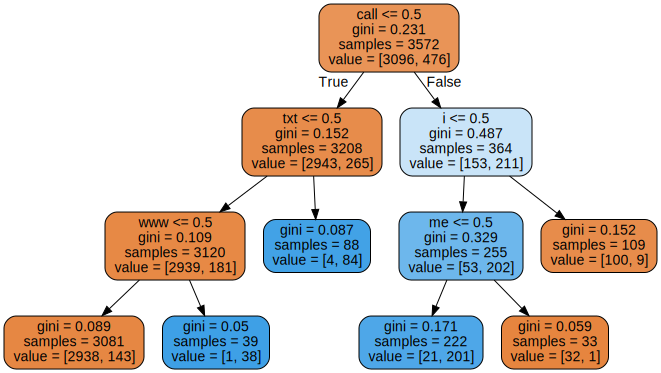

In [19]:
wordlist = list(word_dict.keys())[:-1]
dot_data = tree.export_graphviz(clf, feature_names=wordlist,
                      filled=True, rounded=True) 
graph = graphviz.Source(dot_data)	
graph	

How does the number of decision rules affect the accuracy of the model? We'll retrain the model 29 times to see how the accuracy changes as we increase the number of decision rules from 2 to 30.

In [20]:
for leaves in range(2, 31):
  clf = tree.DecisionTreeClassifier(max_leaf_nodes = leaves)	
  clf = clf.fit(traindat, trainlabs)	
  yhat = clf.predict(testdat)
  acc = sum([yhat[i] == testlabs[i] for i in range(len(testdat))])/len(testdat)
  print(leaves,acc)

2 0.888
3 0.913
4 0.931
5 0.937
6 0.9415
7 0.942
8 0.9385
9 0.9425
10 0.945
11 0.9475
12 0.9505
13 0.952
14 0.9525
15 0.9535
16 0.9535
17 0.9535
18 0.959
19 0.959
20 0.9585
21 0.96
22 0.957
23 0.9575
24 0.958
25 0.9585
26 0.9585
27 0.9585
28 0.958
29 0.9585
30 0.9585


Let's now fit a naive Bayes model and print the accuracy of the model


In [21]:
clf = MultinomialNB().fit(traindat, trainlabs)
clf = clf.fit(traindat, trainlabs)	
yhat = clf.predict(testdat)
acc = sum([yhat[i] == testlabs[i] for i in range(len(testdat))])/len(testdat)
acc

0.985

We can also calculate the confusion matrix of the model, a table of the following counts:

True Negatives False Positives

False Negatives True Positives

In [13]:
print(confusion_matrix(testlabs, yhat))

[[1724    5]
 [  25  246]]


Let's visualize how Naive Bayes combines information from words in a sentence to make a judgement.

In [29]:
import numpy as np

def plotsentence(sentence, clf):
  acc = 1.0
  labs = []
  facs = []
  factor = np.exp(clf.class_log_prior_[0]- clf.class_log_prior_[1])
  labs += ["PRIOR"]
  facs += [factor]
  acc *= factor
  for w in sentence:
    i = word_dict[w]
    factor = np.exp(clf.feature_log_prob_[0][i]- clf.feature_log_prob_[1][i])
    labs += [w]
    facs += [factor]
    acc *= factor
  labs += ["POST"]
  facs += [acc]
  return((labs,facs))

In [65]:
(labs,facs) = plotsentence(['yo', 'come', 'over', 'carlos', 'will', 'be', 'here', 'soon'], clf)
facs = [ fac if fac >= 1.0 else -1/fac for fac in facs ]
[(l,round(f,1)) for (l,f) in zip(labs,facs)]

[('PRIOR', 6.5),
 ('yo', 8.0),
 ('come', 15.5),
 ('over', 1.4),
 ('carlos', 4.9),
 ('will', 1.9),
 ('be', 1.4),
 ('here', 6.7),
 ('soon', 3.4),
 ('POST', 347592.0)]

In [68]:
(labs,facs) = plotsentence(['congratulations', 'thanks', 'to', 'a', 'good', 'friend', 'u', 'have', 'won'], clf)
facs = [ fac if fac >= 1.0 else -1/fac for fac in facs ]
[(l,round(f,1)) for (l,f) in zip(labs,facs)]

[('PRIOR', 6.5),
 ('congratulations', -11.4),
 ('thanks', -1.1),
 ('to', -1.4),
 ('a', -1.2),
 ('good', 4.7),
 ('friend', -1.3),
 ('u', 2.0),
 ('have', -1.1),
 ('won', -12.6),
 ('POST', -6.0)]